##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 在 Tensorflow 中训练提升树（Boosted Trees）模型

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://tensorflow.google.cn/tutorials/estimator/boosted_trees"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png" />在 tensorFlow.google.cn 上查看</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/estimator/boosted_trees.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png" />在 Google Colab 中运行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/estimator/boosted_trees.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/estimator/boosted_trees.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png" />下载此 notebook</a>
  </td>
</table>

Note: 我们的 TensorFlow 社区翻译了这些文档。因为社区翻译是尽力而为， 所以无法保证它们是最准确的，并且反映了最新的
[官方英文文档](https://tensorflow.google.cn/?hl=en)。如果您有改进此翻译的建议， 请提交 pull request 到
[tensorflow/docs](https://github.com/tensorflow/docs) GitHub 仓库。要志愿地撰写或者审核译文，请加入
[docs-zh-cn@tensorflow.org Google Group](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-zh-cn)。

本教程是使用基于 `tf.estimator` API的决策树来训练梯度提升模型的端到端演示。提升树（Boosted Trees）模型是回归和分类问题中最受欢迎并最有效的机器学习方法之一。这是一种融合技术，它结合了几个（10 个，100 个或者甚至 1000 个）树模型的预测值。

提升树（Boosted Trees）模型受到许多机器学习从业者的欢迎，因为它们可以通过最小化的超参数调整获得令人印象深刻的性能。

## 加载泰坦尼克数据集

您将使用泰坦尼克数据集，该数据集的目标是在给出性别、年龄、阶级等特征的条件下预测乘客幸存与否。

In [0]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
from matplotlib import pyplot as plt

# 加载数据集。
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [0]:
import tensorflow as tf
tf.random.set_seed(123)

数据集由训练集和验证集组成：

* `dftrain` 与 `y_train` 是*训练集*——模型用来学习的数据。
* 模型根据*评估集*，`dfeval` 和 `y_eval` 进行测试。

您将使用以下特征来进行训练：

<table>
  <tr>
    <th>特征名称</th>
    <th>描述</th>
  </tr>
  <tr>
    <td>sex</td>
    <td>乘客的性别</td>
  </tr>
  <tr>
    <td>age</td>
    <td>乘客的年龄</td>
  </tr>
    <tr>
    <td>n_siblings_spouses</td>
    <td>船上的兄弟姐妹与伙伴</td>
  </tr>
    <tr>
    <td>parch</td>
    <td>船上的父母与孩子</td>
  </tr>
    <tr>
    <td>fare</td>
    <td>乘客所支付的票价</td>
  </tr>
    <tr>
    <td>class</td>
    <td>乘客在船上的舱室等级</td>
  </tr>
    <tr>
    <td>deck</td>
    <td>哪个甲板上的乘客</td>
  </tr>
    <tr>
    <td>embark_town</td>
    <td>乘客是从哪个城镇上船的</td>
  </tr>
    <tr>
    <td>alone</td>
    <td>是否乘客独自一人</td>
  </tr>
</table>

## 探索数据

让我们首先预览一些数据，并在训练集上创建摘要统计。

In [0]:
dftrain.head()

sex   age  n_siblings_spouses  parch  ...  class     deck  embark_town alone
0    male  22.0                   1      0  ...  Third  unknown  Southampton     n
1  female  38.0                   1      0  ...  First        C    Cherbourg     n
2  female  26.0                   0      0  ...  Third  unknown  Southampton     y
3  female  35.0                   1      0  ...  First        C  Southampton     n
4    male  28.0                   0      0  ...  Third  unknown   Queenstown     y

[5 rows x 9 columns]

In [0]:
dftrain.describe()

age  n_siblings_spouses       parch        fare
count  627.000000          627.000000  627.000000  627.000000
mean    29.631308            0.545455    0.379585   34.385399
std     12.511818            1.151090    0.792999   54.597730
min      0.750000            0.000000    0.000000    0.000000
25%     23.000000            0.000000    0.000000    7.895800
50%     28.000000            0.000000    0.000000   15.045800
75%     35.000000            1.000000    0.000000   31.387500
max     80.000000            8.000000    5.000000  512.329200

训练集和评估集分别有 627 和 264 个样本。

In [0]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

大多数乘客在 20 岁或 30 岁。

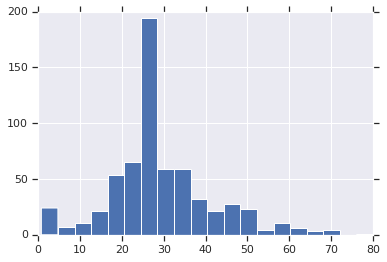

In [0]:
dftrain.age.hist(bins=20)
plt.show()

男乘客大约是女乘客的两倍。

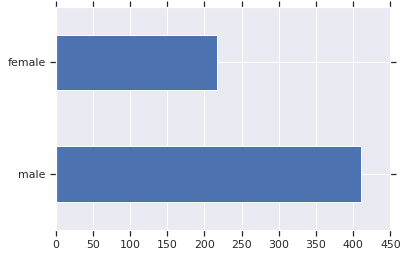

In [0]:
dftrain.sex.value_counts().plot(kind='barh')
plt.show()

大多数乘客都在“三等”舱。

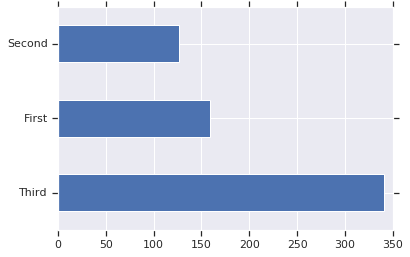

In [0]:
dftrain['class'].value_counts().plot(kind='barh')
plt.show()

大多数乘客从南安普顿出发。

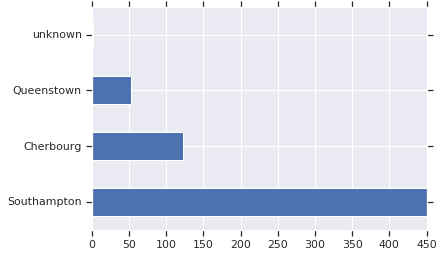

In [0]:
dftrain['embark_town'].value_counts().plot(kind='barh')
plt.show()

与男性相比，女性存活的几率要高得多。这显然是该模型的预测特征。

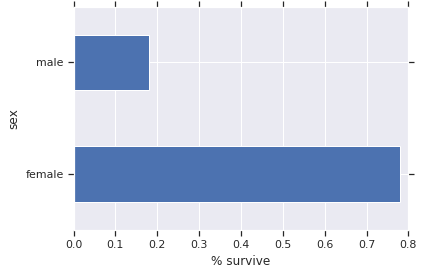

In [0]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')
plt.show()

## 创建特征列与输入函数

梯度提升（Gradient Boosting） Estimator 可以利用数值和分类特征。特征列适用于所有的 Tensorflow estimator，其目的是定义用于建模的特征。此外，它们还提供一些特征工程功能，如独热编码（one-hot-encoding）、标准化（normalization）和桶化（bucketization）。在本教程中，`CATEGORICAL_COLUMNS` 中的字段从分类列转换为独热编码列([指标列](https://tensorflow.google.cn/api_docs/python/tf/feature_column/indicator_column))：


In [0]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))

您可以查看特征列生成的转换。例如，以下是在单个样本中使用 `indicator_column` 的输出：

In [0]:
example = dict(dftrain.head(1))
class_fc = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('class', ('First', 'Second', 'Third')))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

Feature value: "Third"
One-hot encoded:  [[ 0.  0.  1.]]


此外，您还可以一起查看所有特征列的转换：

In [0]:
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

array([[ 22.  ,   1.  ,   0.  ,   1.  ,   0.  ,   0.  ,   1.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,
          0.  ,   0.  ,   7.25,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          1.  ,   0.  ]], dtype=float32)

接下来，您需要创建输入函数。这些将指定如何将数据读入到我们的模型中以供训练与推理。您将使用 [`tf.data`](https://tensorflow.google.cn/api_docs/python/tf/data)API 中的 `from_tensor_slices` 方法直接从 Pandas 中读取数据。这适用于较小的内存数据集。对于较大的数据集，tf.data API 支持各种文件格式（包括 [csv](https://tensorflow.google.cn/api_docs/python/tf/data/experimental/make_csv_dataset)）,以便您能处理那些不适合放入内存中的数据集。

In [0]:
# 使用大小为全部数据的 batch ，因为数据规模非常小.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # 对于训练，可以按需多次循环数据集（n_epochs=None）。
    dataset = dataset.repeat(n_epochs)
    # 在内存中训练不使用 batch。
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# 训练与评估的输入函数。
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

## 训练与评估模型

您将执行以下步骤：

1. 初始化模型，指定特征和超参数。
2. 使用 `train_input_fn` 将训练数据输入模型，使用 `train` 函数训练模型。
3. 您将使用此示例中的评估集评估模型性能，即 `dfeval` DataFrame。您将验证预测是否与 `y_eval` 数组中的标签匹配。

在训练提升树（Boosted Trees）模型之前，让我们先训练一个线性分类器（逻辑回归模型）。最好的做法是从更简单的模型开始建立基准。


In [0]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# 训练模型。
linear_est.train(train_input_fn, max_steps=100)

# 评估。
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
global_step             100.000000
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
dtype: float64


下面让我们训练提升树（Boosted Trees）模型。提升树（Boosted Trees）是支持回归（`BoostedTreesRegressor`）和分类（`BoostedTreesClassifier`）的。由于目标是预测一个生存与否的标签，您将使用 `BoostedTreesClassifier`。

In [0]:
# 由于数据存入内存中，在每层使用全部数据会更快。
# 上面一个 batch 定义为整个数据集。
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# 一旦建立了指定数量的树，模型将停止训练，
# 而不是基于训练步数。
est.train(train_input_fn, max_steps=100)

# 评估。
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.829545
accuracy_baseline         0.625000
auc                       0.872788
auc_precision_recall      0.857807
average_loss              0.411839
global_step             100.000000
label/mean                0.375000
loss                      0.411839
precision                 0.793478
prediction/mean           0.381942
recall                    0.737374
dtype: float64


现在您可以使用训练的模型从评估集上对乘客进行预测了。Tensorflow 模型经过优化，可以同时在一个 batch 或一个集合的样本上进行预测。之前，`eval_inout_fn` 是使用整个评估集定义的。

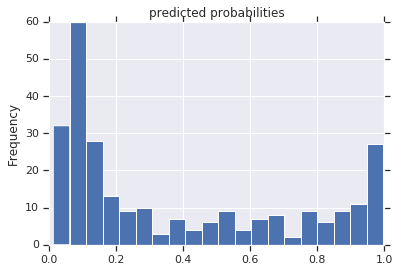

In [0]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

最后，您还可以查看结果的受试者工作特征曲线（ROC），这将使我们更好地了解真阳性率与假阴性率之间的权衡。

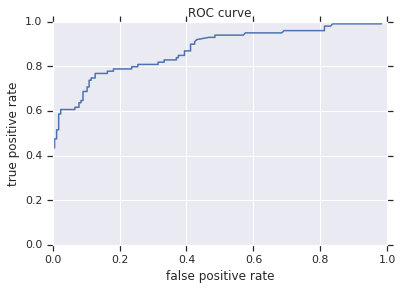

In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()